In [1]:
from os import listdir
from PIL import Image as PImage
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import image_dataset_from_directory
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.optimizers import SGD

In [38]:
image_size_x = 48
image_size_y = 48

dataset_train = image_dataset_from_directory("../data/fer2013/train/", labels='inferred',image_size=(image_size_x,image_size_y))
dataset_test = image_dataset_from_directory("../data/fer2013/test/", labels='inferred',image_size=(image_size_x,image_size_y))

Found 28709 files belonging to 7 classes.
Found 7178 files belonging to 7 classes.


In [4]:
class_names = dataset_train.class_names
print(class_names)

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [5]:
AUTOTUNE = tf.data.AUTOTUNE
dataset_train = dataset_train.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
print(dataset_train)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 48, 48, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [39]:
num_classes = len(class_names)

model = keras.Sequential([
  layers.Rescaling(1./255, input_shape=(image_size_x , image_size_y,3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

# verändert von https://blog.devgenius.io/facial-expression-recognition-with-tensorflow-90f6174163c3
#model = keras.Sequential([
#    layers.Rescaling(1./255, input_shape=(image_size_x , image_size_y,1)),
#    tf.keras.layers.Conv2D(512, 3, activation="relu", padding="same"),
#    layers.BatchNormalization(),
#    tf.keras.layers.Conv2D(256, 3, activation="relu", padding="same"),
#    layers.BatchNormalization(),
#    tf.keras.layers.MaxPool2D(2),
#    tf.keras.layers.Dropout(0.5),
#    tf.keras.layers.Conv2D(128, (3,3), activation="relu", padding="same"),
#    layers.BatchNormalization(),
#    tf.keras.layers.Conv2D(64, (3,3), activation="relu", padding="same"),
#    layers.BatchNormalization(),
#    tf.keras.layers.MaxPool2D(2),
#    tf.keras.layers.Dropout(0.5),
#    tf.keras.layers.Conv2D(32, 3, activation="relu", padding="same"),
#    tf.keras.layers.MaxPool2D(2),
#    tf.keras.layers.Dropout(0.5),
#    tf.keras.layers.Flatten(),
# layers.Dense(128, activation='relu'),
#  layers.Dense(num_classes)])

In [40]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 48, 48, 3)         0         
                                                                 
 conv2d_6 (Conv2D)           (None, 48, 48, 16)        448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 24, 24, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 24, 24, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 12, 12, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 12, 12, 64)       

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


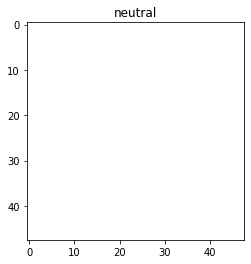

In [54]:
for images, labels in dataset_train.take(1):
    first_image_of_batch = images.numpy()[0]
    first_label_of_batch = labels.numpy()[0]
    assert(image_size_x * image_size_y * 3 == first_image_of_batch.size)
    fig = plt.figure(frameon=False)
    plt.imshow(first_image_of_batch.reshape(image_size_x,image_size_y,3),cmap="gray")
    plt.title(class_names[first_label_of_batch])


<BarContainer object of 10 artists>

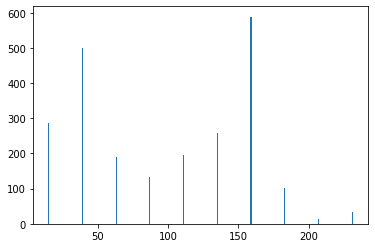

In [9]:
H, bins = np.histogram(iter(dataset_train.take(1)).next()[0][0].numpy())

plt.bar(bins[:-1],H)

In [42]:
epochs=5
history = model.fit(
  dataset_train,
  validation_data=dataset_test,
  epochs=epochs
)


Epoch 1/5
898/898 [==============================] - 46s 51ms/step - loss: 1.6508 - accuracy: 0.3409 - val_loss: 1.4607 - val_accuracy: 0.4415
Epoch 2/5
898/898 [==============================] - 46s 51ms/step - loss: 1.3922 - accuracy: 0.4680 - val_loss: 1.3241 - val_accuracy: 0.4990
Epoch 3/5
898/898 [==============================] - 46s 51ms/step - loss: 1.2491 - accuracy: 0.5282 - val_loss: 1.2478 - val_accuracy: 0.5227
Epoch 4/5
898/898 [==============================] - 45s 50ms/step - loss: 1.1540 - accuracy: 0.5636 - val_loss: 1.2122 - val_accuracy: 0.5371
Epoch 5/5
898/898 [==============================] - 47s 53ms/step - loss: 1.0683 - accuracy: 0.5998 - val_loss: 1.1971 - val_accuracy: 0.5485


In [43]:
def showHistory(history, epochs):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')


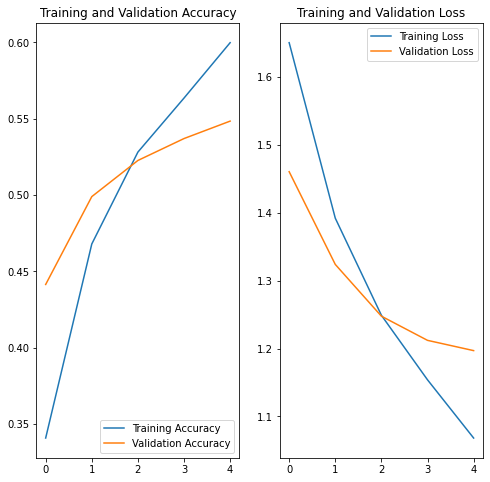

In [44]:
showHistory(history,epochs)

Diese Plots zeigen Overfitting, deshalb muss dem entgegengewirkt werden. Hierfür werden zwei Änderungen eingeführt:
- Data-Augmentation: Leichtes Verändern der Input-Bilder um "genereller" zu lernen
- Dropout 

In [45]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(image_size_x,
                                  image_size_y,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

In [46]:
model = keras.Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(48, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu' ),
  layers.Dense(num_classes,activation='softmax')
])


In [47]:
model.compile(optimizer="adam",
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])


In [ ]:
model.summary()

In [48]:
epochs=5
history = model.fit(
  dataset_train,
  validation_data=dataset_test,
  epochs=epochs
)

Epoch 1/5
898/898 [==============================] - 69s 76ms/step - loss: 1.7498 - accuracy: 0.2777 - val_loss: 1.6471 - val_accuracy: 0.3451
Epoch 2/5
898/898 [==============================] - 70s 78ms/step - loss: 1.6293 - accuracy: 0.3579 - val_loss: 1.4775 - val_accuracy: 0.4274
Epoch 3/5
898/898 [==============================] - 70s 78ms/step - loss: 1.5187 - accuracy: 0.4085 - val_loss: 1.3936 - val_accuracy: 0.4634
Epoch 4/5
898/898 [==============================] - 70s 78ms/step - loss: 1.4424 - accuracy: 0.4442 - val_loss: 1.3324 - val_accuracy: 0.4862
Epoch 5/5
898/898 [==============================] - 71s 79ms/step - loss: 1.3976 - accuracy: 0.4606 - val_loss: 1.3567 - val_accuracy: 0.4792


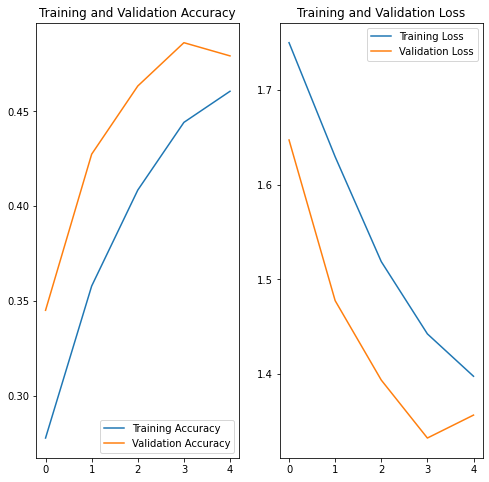

In [49]:
showHistory(history,epochs)

In [20]:
from alibi.explainers import AnchorImage

In [50]:
predict_fn = lambda x: model.predict(x)

4/4 [==============================] - 0s 9ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


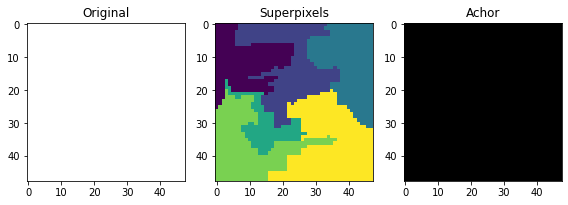

In [52]:
image= first_image_of_batch.reshape(image_size_x,image_size_y,3)

segmentation_fn = 'felzenszwalb'
kwargs = {'scale': 700}

explainer = AnchorImage(predict_fn, image.shape)


np.random.seed(42)
explanation = explainer.explain(image, threshold=.95, p_sample=.5, tau=0.25)
original = image

fig, axes = plt.subplots(1, 3, figsize=(8, 4))
ax = axes.ravel()

ax[0].imshow(original)
ax[0].set_title("Original")
ax[1].imshow(explanation.segments)
ax[1].set_title("Superpixels")
ax[2].imshow(explanation.anchor)
ax[2].set_title("Achor")

fig.tight_layout()
plt.show()

Nächste Schritte:
- "Neue" Klassifikation: "Happy" und "Not-Happy"
- Literatur-Recherche zu FER2013 -> Welche Modelle schneiden besser ab?
- Preprocessing der Bilder (z.B. Helligkeits-Angleichung o.Ä.)
- Erweiterung der Datenbasis?
- Weiter Einarbeitung in CNNs

In [ ]:
Probleme: Alibi braucht 3 farbchanncels. anscheinend hat das einlesen hier nicht geklappt